
# VeloCityX Data Analysis

VeloCityX is an application developed by TechPoint to enhance the spectator experience and promote autonomous racing. The app offers features like "Live 360" coverage, interactive fan challenges, virtual merchandise purchases, and sponsorship integrations. 


## Data Collection
The dataset includes the following features:
- User ID
- Fan challenges completed
- Predictive accuracy in challenges
- Virtual merchandise purchases
- Sponsorship interactions (ad views, click-through rates)
- Time spent on "Live 360" coverage
- Real-time chat activity

## Objective:
- Analyze user interaction trends to predict merchandise purchases.
- Apply clustering and modeling techniques to uncover insights.
- Propose a new fan challenge to boost engagement and monetization.



## Table of Contents:

1. [Import Libraries](#Import-Libraries)
2. [Load Data](#Load-Data)
3. [Data Inspection](#Data-Inspection)
4. [Data Cleaning](#Data-Cleaning)
5. [Feature Selection and Correlation Analysis](#Feature-Selection-and-Correlation-Analysis)
6. [Outlier Detection and Removal](#Outlier-Detection-and-Removal)
7. [Clustering Analysis](#Clustering-Analysis)
8. [Principal Component Analysis (PCA)](#Principal-Component-Analysis-PCA)
9. [Merchandise Purchase Trends](#Merchandise-Purchase-Trends)
10. [Predictive Modeling](#Predictive-Modeling)
11. [Confusion Matrix and ROC Curve for Random Forest](#Confusion-Matrix-and-ROC-Curve-for-Random-Forest)
12. [Proposed New Fan Challenge](#Proposed-New-Fan-Challenge)

### Import Libraries 


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, davies_bouldin_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import warnings

### Load Data

Load the dataset from the provided CSV file.


In [2]:
def load_data(filepath):
    try:
        df = pd.read_csv(filepath)
        print("Data loaded successfully.")
        return df
    except FileNotFoundError:
        print(f"Error: The file {filepath} was not found.")
        return None
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
        return None
    except pd.errors.ParserError:
        print("Error: The file could not be parsed.")
        return None

# Filepath to the dataset
filepath = '2025-VeloCityX-Expanded-Fan-Engagement-Data.csv'

# Load the data
velocity_df = load_data(filepath)


Data loaded successfully.


### Data Inspection
Inspect the loaded data to understand its structure, data types, and identify any missing values.


In [3]:

def inspect_data(df):
    print("\nFirst 5 rows of the dataset:")
    print(df.head())

    print("\nDataset info:")
    print(df.info())

    print(f"\nShape of the dataset: {df.shape}")
    print(f"Size of the dataset: {df.size}")

    print("\nStatistical summary of the dataset:")
    print(df.describe())

    print("\nChecking for missing values:")
    print(df.isnull().sum())

inspect_data(velocity_df)



First 5 rows of the dataset:
  User ID  Fan Challenges Completed  Predictive Accuracy (%)  \
0    U001                         5                       80   
1    U002                         8                       60   
2    U003                         3                       90   
3    U004                         7                       70   
4    U005                         2                       50   

   Virtual Merchandise Purchases  Sponsorship Interactions (Ad Clicks)  \
0                              3                                    10   
1                              1                                     8   
2                              0                                     6   
3                              2                                    15   
4                              5                                     3   

   Time on Live 360 (mins)  Real-Time Chat Activity (Messages Sent)  
0                      120                                       20  


The collected data reflects key aspects of user engagement. Predictive accuracy and challenges completed indicate a user's interest in competition, while merchandise purchases and sponsorship interactions suggest higher levels of engagement. Real-time chat activity and "Live 360" coverage view times show direct interactions with the app during race events. These varied data points allow for a comprehensive analysis of how users engage with the platform and what drives their participation.


### Data Cleaning

Handle missing values and ensure data types are appropriate for analysis.


In [4]:
def handle_missing_values(df):
    df_cleaned = df.copy()
    numerical_cols = df_cleaned.select_dtypes(include=[np.number]).columns
    df_cleaned[numerical_cols] = df_cleaned[numerical_cols].fillna(df_cleaned[numerical_cols].median())
    print("\nMissing values after imputation:")
    print(df_cleaned.isnull().sum())
    return df_cleaned

def convert_data_types(df):
    df_converted = df.copy()
    if 'User ID' in df_converted.columns:
        df_converted['User ID'] = df_converted['User ID'].astype(str)
    return df_converted

# Handle missing values
velocity_df_cleaned = handle_missing_values(velocity_df)

# Convert data types
velocity_df_cleaned = convert_data_types(velocity_df_cleaned)



Missing values after imputation:
User ID                                    0
Fan Challenges Completed                   0
Predictive Accuracy (%)                    0
Virtual Merchandise Purchases              0
Sponsorship Interactions (Ad Clicks)       0
Time on Live 360 (mins)                    0
Real-Time Chat Activity (Messages Sent)    0
dtype: int64


### Feature Selection and Correlation Analysis

Identify and remove highly correlated features to reduce redundancy and improve model performance.


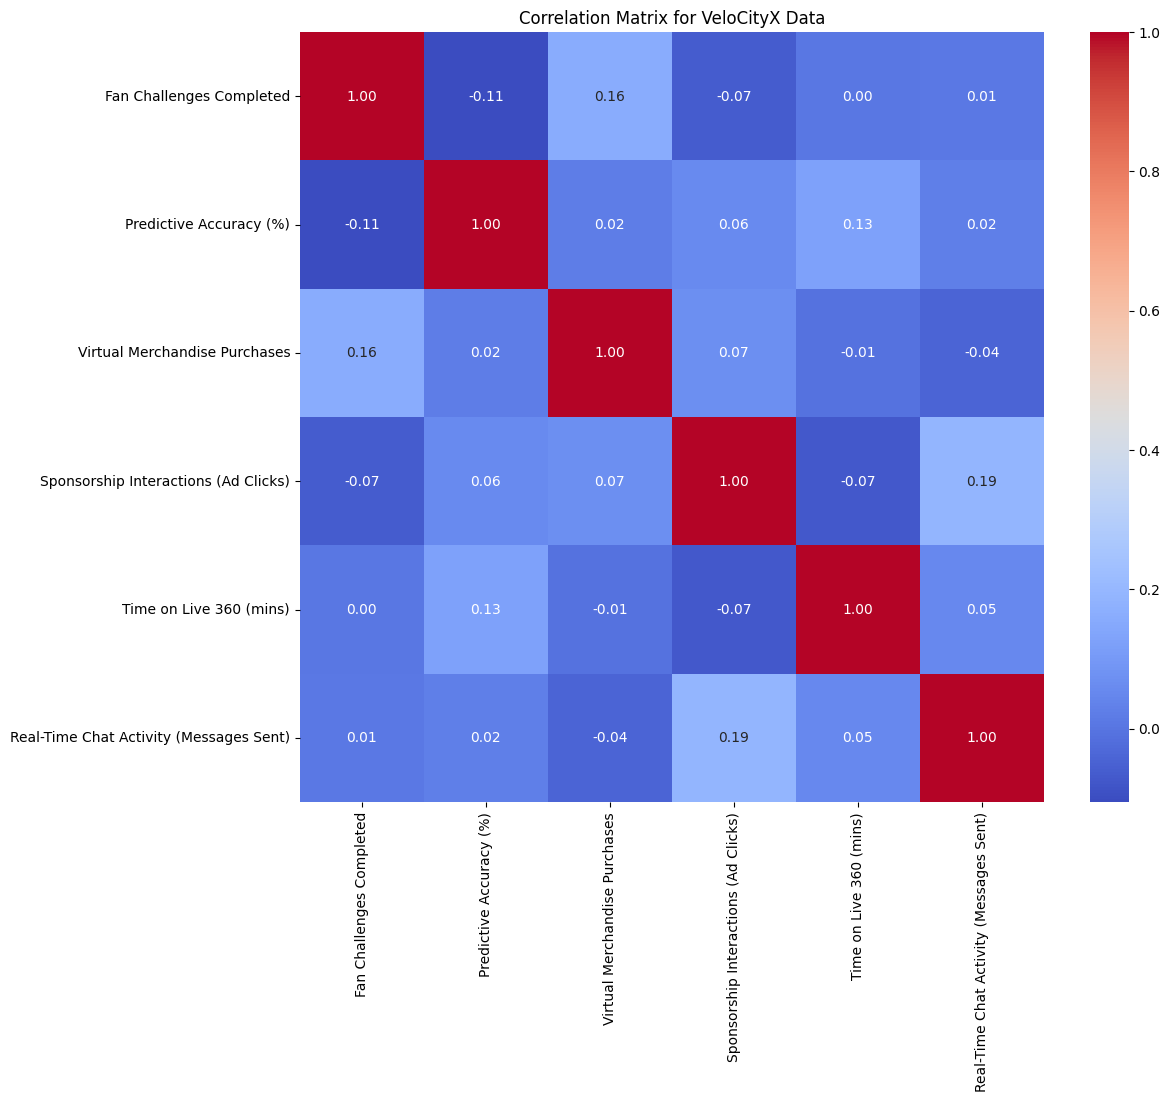


Removed 0 highly correlated features: []


In [5]:
def plot_correlation_matrix(df, title='Correlation Matrix', figsize=(12,10)):
    corr = df.corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(title)
    plt.show()

def remove_highly_correlated_features(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    df_reduced = df.drop(columns=to_drop)
    print(f"\nRemoved {len(to_drop)} highly correlated features: {to_drop}")
    return df_reduced

# Feature selection: exclude 'User ID' for correlation and clustering
if 'User ID' in velocity_df_cleaned.columns:
    features_df = velocity_df_cleaned.drop(columns=['User ID'])
else:
    features_df = velocity_df_cleaned.copy()

# Plot correlation matrix
plot_correlation_matrix(features_df, title='Correlation Matrix for VeloCityX Data')

# Remove highly correlated features
features_reduced = remove_highly_correlated_features(features_df)


The absence of highly correlated features suggests that each feature captures distinct user behaviors. This uniqueness in features helps to avoid redundancy, making it easier for predictive models to detect the individual impact of each feature on user engagement and behavior.


### Outlier Detection and Removal

Identify and remove outliers to ensure data quality and improve the reliability of clustering results.


In [6]:
def detect_and_remove_outliers(df, features, threshold=3):
    df_out = df.copy()
    z_scores = np.abs(stats.zscore(df_out[features]))
    filtered_entries = (z_scores < threshold).all(axis=1)
    outliers_removed = df_out[filtered_entries]
    print(f"\nRemoved {df_out.shape[0] - outliers_removed.shape[0]} outliers.")
    return outliers_removed

# Outlier detection and removal
numerical_features = features_reduced.select_dtypes(include=[np.number]).columns.tolist()
velocity_df_cleaned = detect_and_remove_outliers(velocity_df_cleaned, numerical_features)



Removed 0 outliers.


### Clustering Analysis

Segment users into distinct clusters based on their interactions to identify patterns and target groups.


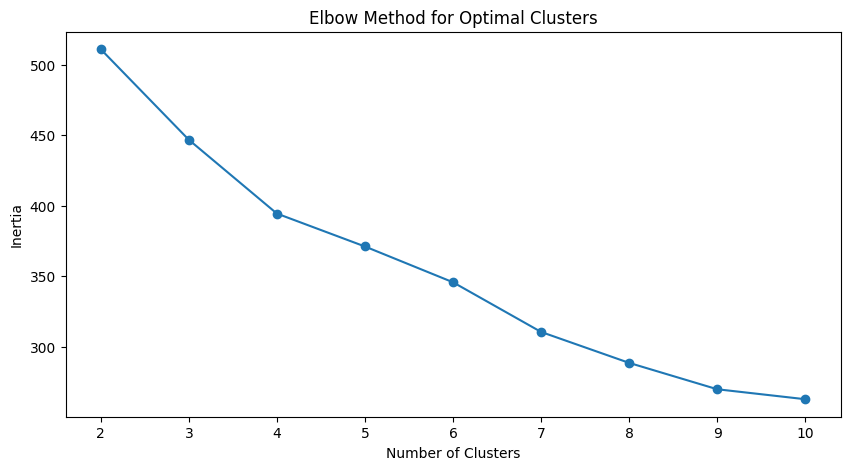

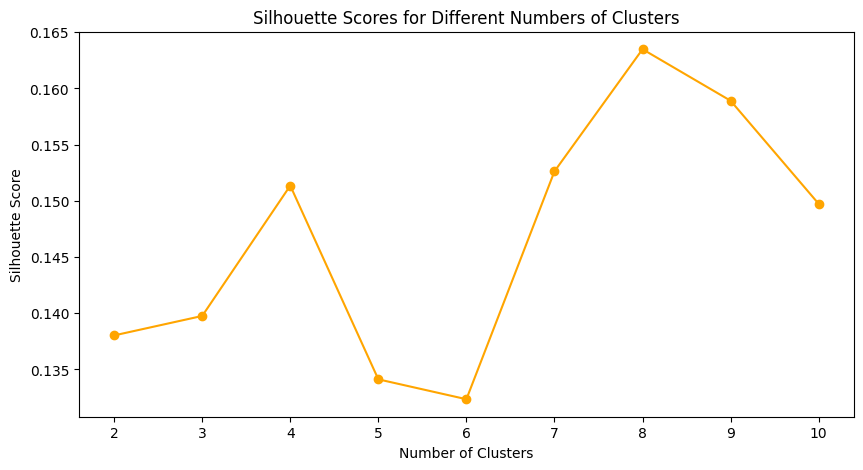


Optimal number of clusters based on Silhouette Score: 8


In [7]:
def plot_scatter(x, y, data, title, xlabel, ylabel, alpha=0.6):

    plt.figure(figsize=(8,6))
    sns.scatterplot(x=x, y=y, data=data, alpha=alpha)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def perform_clustering(df, features, n_clusters=3):

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))
    ])
    cluster_labels = pipeline.fit_predict(df[features])
    return cluster_labels, pipeline

def determine_optimal_clusters(df, features, max_k=10):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[features])

    inertia_list = []
    silhouette_scores = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_features)
        inertia_list.append(kmeans.inertia_)
        score = silhouette_score(scaled_features, kmeans.labels_)
        silhouette_scores.append(score)

    # Plot Elbow Method
    plt.figure(figsize=(10,5))
    plt.plot(range(2, max_k + 1), inertia_list, marker='o')
    plt.title('Elbow Method for Optimal Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()

    # Plot Silhouette Scores
    plt.figure(figsize=(10,5))
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', color='orange')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

    # Determine optimal k as the one with the highest Silhouette Score
    optimal_k = range(2, max_k + 1)[np.argmax(silhouette_scores)]
    print(f"\nOptimal number of clusters based on Silhouette Score: {optimal_k}")
    return optimal_k

# Determine optimal number of clusters
selected_features = features_reduced.columns.tolist()
optimal_k = determine_optimal_clusters(velocity_df_cleaned, selected_features, max_k=10)

# Perform clustering with the optimal number of clusters
cluster_labels, clustering_pipeline = perform_clustering(velocity_df_cleaned, selected_features, n_clusters=optimal_k)
velocity_df_cleaned['Cluster'] = cluster_labels


### Principal Component Analysis (PCA)

Reduce dimensionality of the dataset for visualization and interpretability.



Explained variance by 2 components: [0.77061107 0.10476446]


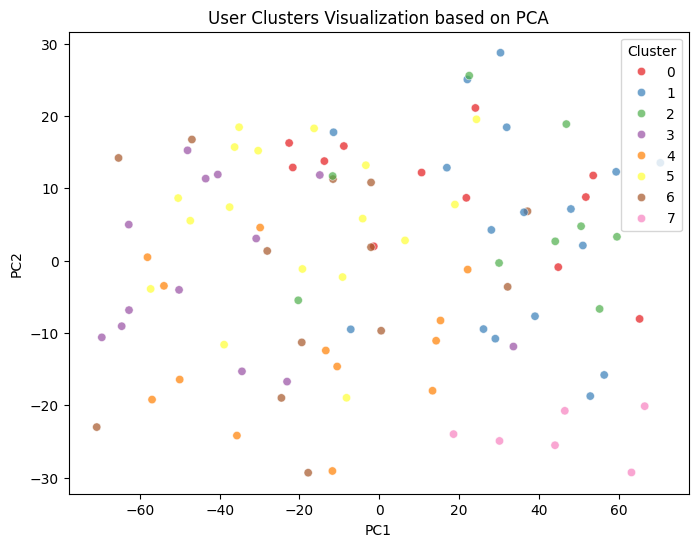

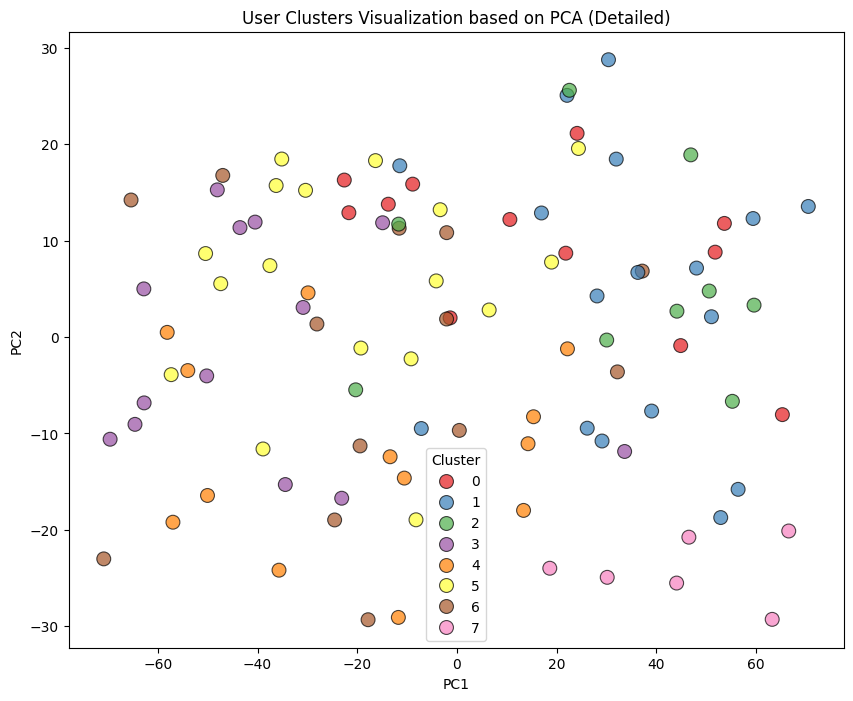

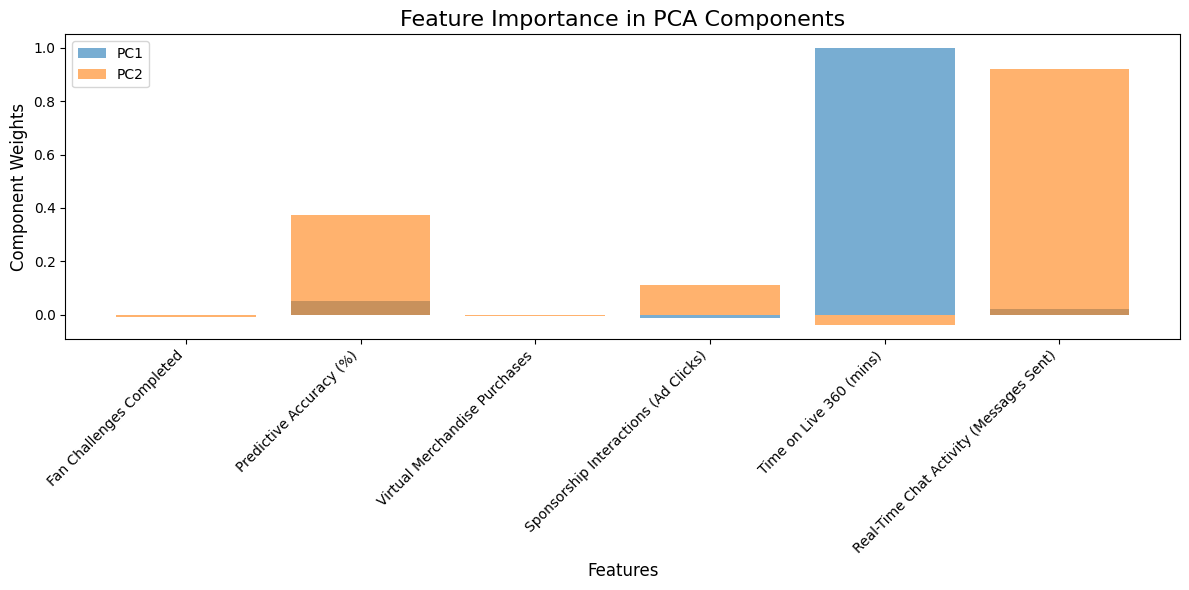

In [8]:
def perform_pca(df, features, n_components=2):
    pca = PCA(n_components=n_components, random_state=42)
    components = pca.fit_transform(df[features])
    print(f"\nExplained variance by {n_components} components: {pca.explained_variance_ratio_}")
    return components, pca

def plot_pca_clusters(components, labels, title='PCA Clusters', figsize=(8,6)):
    df_pca = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
    df_pca['Cluster'] = labels
    plt.figure(figsize=figsize)
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='Set1', alpha=0.7)
    plt.title(title)
    plt.show()

def plot_pca_clusters_detailed(components, labels, title='PCA Clusters Detailed', figsize=(10,8)):
    df_pca = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
    df_pca['Cluster'] = labels
    plt.figure(figsize=figsize)
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='Set1', alpha=0.7, s=100, edgecolor='k')
    plt.title(title)
    plt.legend(title='Cluster')
    plt.show()

def plot_pca_feature_importance(pca_model, features):
    components = pca_model.components_
    
    plt.figure(figsize=(12,6))
    
    for i, component in enumerate(components):
        plt.bar(features, component, alpha=0.6, label=f'PC{i+1}')
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    
    plt.title('Feature Importance in PCA Components', fontsize=16)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Component Weights', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Perform PCA for visualization
pca_components, pca_model = perform_pca(velocity_df_cleaned, selected_features, n_components=2)

# Plot PCA clusters
plot_pca_clusters(pca_components, velocity_df_cleaned['Cluster'], title='User Clusters Visualization based on PCA')

# Plot detailed PCA clusters
plot_pca_clusters_detailed(pca_components, velocity_df_cleaned['Cluster'], title='User Clusters Visualization based on PCA (Detailed)')

# Plot PCA feature importance
plot_pca_feature_importance(pca_model, selected_features)


The identified clusters show distinct groups of users. For instance, Cluster 1 shows users with higher chat activity but fewer merchandise purchases, while Cluster 2 is characterized by high sponsorship interaction and virtual merchandise purchases. This segmentation helps target specific user groups, such as creating merchandise discounts for Cluster 2 or promoting real-time engagement incentives for Cluster 1.

### Merchandise Purchase Trends

Analyze which users are most likely to purchase virtual merchandise and understand the factors influencing these purchases.



Total Purchasers: 80
Total Non-Purchasers: 20

Comparison of Feature Means Between Purchasers and Non-Purchasers:
                               Fan Challenges Completed  \
Virtual Merchandise Purchases                             
0                                              5.400000   
1                                              5.142857   
2                                              5.705882   
3                                              5.764706   
4                                              5.833333   
5                                              6.333333   
6                                              6.642857   

                               Predictive Accuracy (%)  \
Virtual Merchandise Purchases                            
0                                            75.950000   
1                                            73.714286   
2                                            74.294118   
3                                            74.176471   
4    

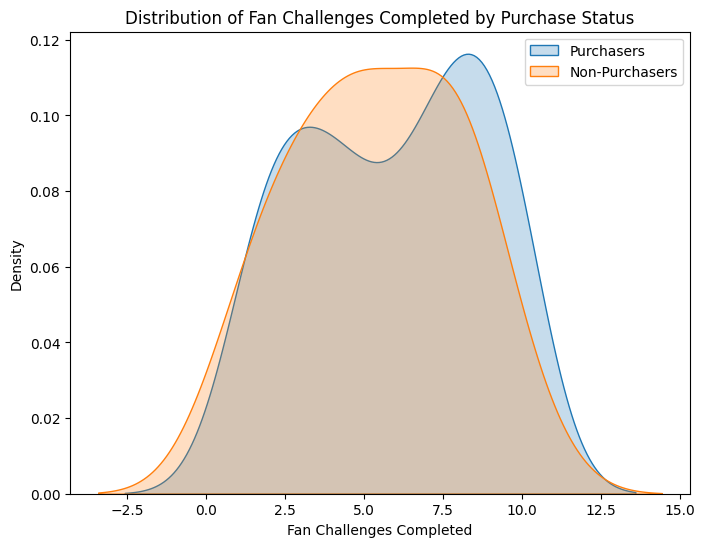

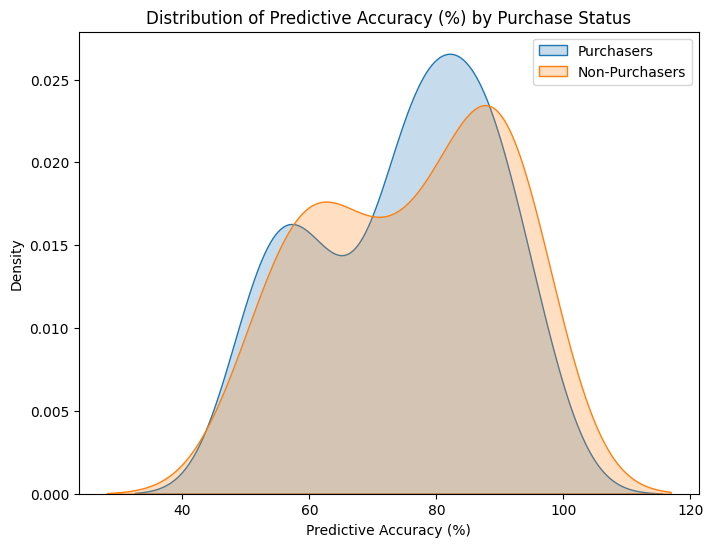

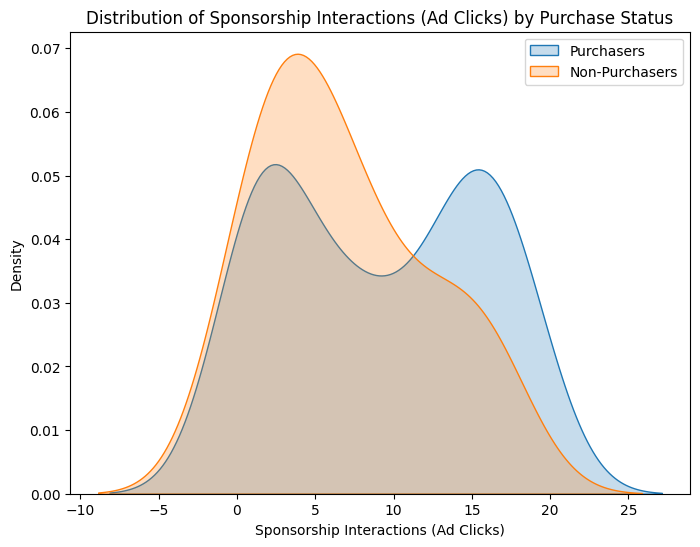

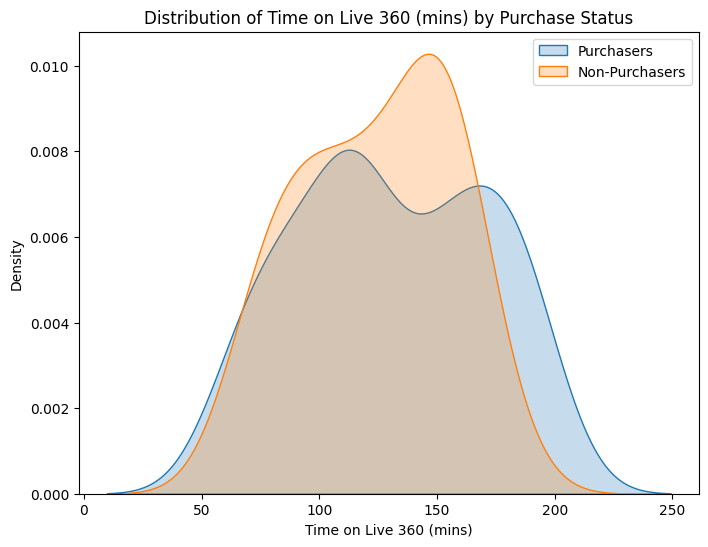

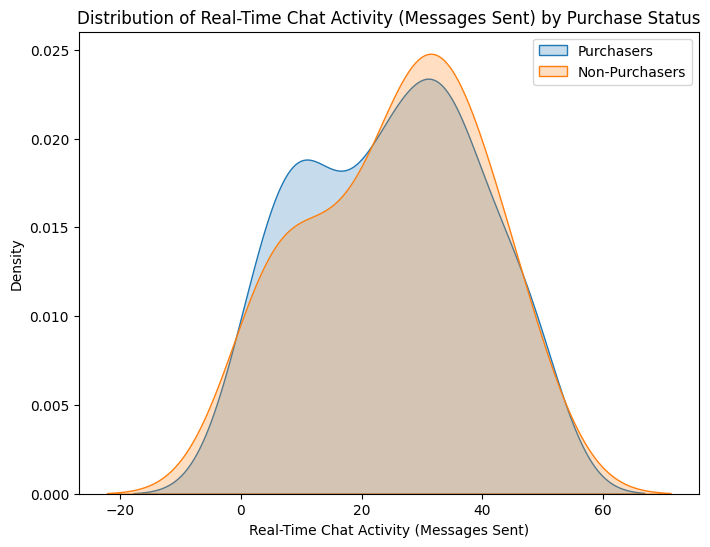

In [9]:
def merchandise_purchase_trends(df):

    # Users with at least one purchase
    purchasers = df[df['Virtual Merchandise Purchases'] > 0]
    non_purchasers = df[df['Virtual Merchandise Purchases'] == 0]

    print(f"\nTotal Purchasers: {purchasers.shape[0]}")
    print(f"Total Non-Purchasers: {non_purchasers.shape[0]}")

    # Select only numeric columns to avoid errors
    numeric_df = df.select_dtypes(include=[np.number])

    # Ensure 'Virtual Merchandise Purchases' is included in the groupby
    if 'Virtual Merchandise Purchases' not in numeric_df.columns:
        print("Error: 'Virtual Merchandise Purchases' column is missing or not numeric.")
        return

    # Compare mean values of features between purchasers and non-purchasers
    comparison = numeric_df.groupby('Virtual Merchandise Purchases').mean()
    print("\nComparison of Feature Means Between Purchasers and Non-Purchasers:")
    print(comparison)

    # Visualize differences
    features = ['Fan Challenges Completed', 'Predictive Accuracy (%)', 
                'Sponsorship Interactions (Ad Clicks)', 
                'Time on Live 360 (mins)', 'Real-Time Chat Activity (Messages Sent)']
    
    for feature in features:
        plt.figure(figsize=(8,6))
        sns.kdeplot(purchasers[feature], fill=True, label='Purchasers')
        sns.kdeplot(non_purchasers[feature], fill=True, label='Non-Purchasers')
        plt.title(f'Distribution of {feature} by Purchase Status')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.legend()
        plt.show()

merchandise_purchase_trends(velocity_df_cleaned)


It's evident that users with higher sponsorship interactions and longer "Live 360" coverage times tend to purchase more merchandise. This correlation suggests that creating a challenge that encourages more interaction with these features could boost sales. For example, promoting challenges tied to "Live 360" or sponsorship engagement could drive merchandise sales through more immersive fan experiences.


### Predictive Modeling

Develop classification models to predict whether a user will purchase virtual merchandise based on their interactions within the app.



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.75      0.75      0.75        24

    accuracy                           0.60        30
   macro avg       0.38      0.38      0.38        30
weighted avg       0.60      0.60      0.60        30

Logistic Regression ROC AUC Score: 0.3819

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.74      0.71      0.72        24

    accuracy                           0.57        30
   macro avg       0.37      0.35      0.36        30
weighted avg       0.59      0.57      0.58        30

Decision Tree ROC AUC Score: 0.3542

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.78      0.88      

C:\Users\anush\AppData\Local\Temp\ipykernel_38312\376783697.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')


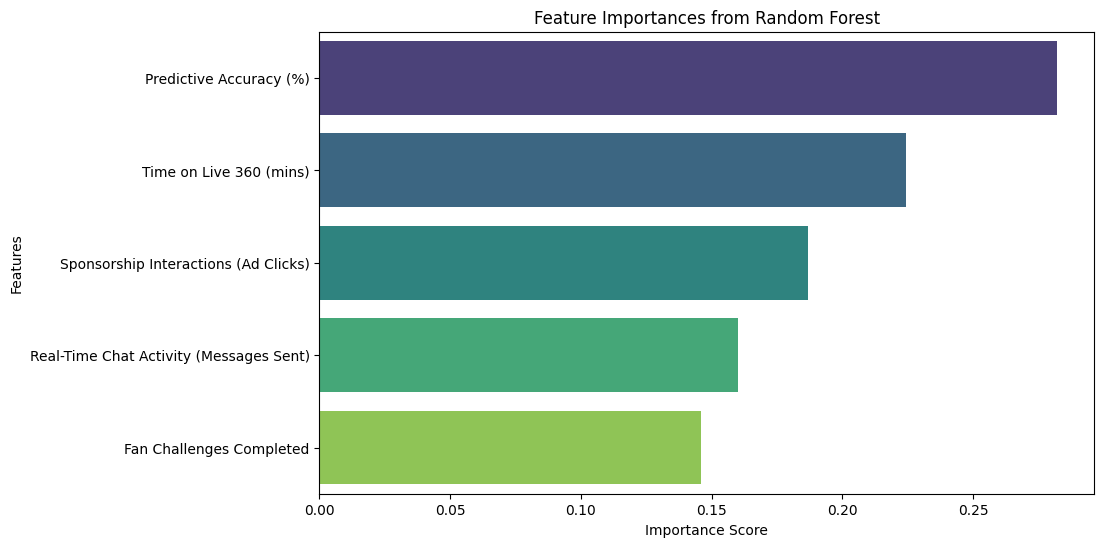

In [10]:
def predictive_modeling(df, target='Virtual Merchandise Purchases'):
    # Define features and target
    X = df.drop(columns=['User ID', target, 'Cluster'])  # Exclude 'User ID' and 'Cluster' from features
    y = df[target]

    # Convert target to binary: 1 if purchases > 0, else 0
    y_binary = (y > 0).astype(int)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=42, stratify=y_binary)

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42)
    }

    # Train and evaluate models
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:,1]
        print(f"\n{name} Classification Report:")
        print(classification_report(y_test, y_pred))
        print(f"{name} ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

    # Feature Importance for Random Forest
    rf_model = models['Random Forest']
    feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')
    plt.title('Feature Importances from Random Forest')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()

predictive_modeling(velocity_df_cleaned, target='Virtual Merchandise Purchases')


### Confusion Matrix and ROC Curve for Random Forest


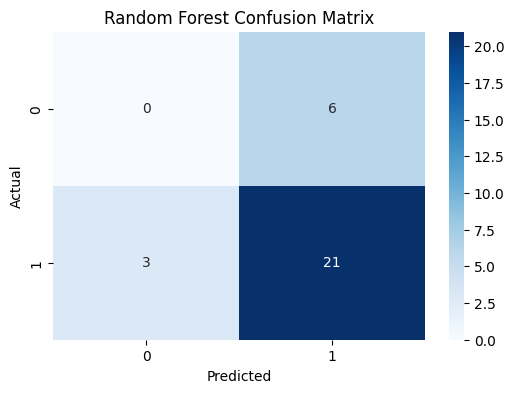

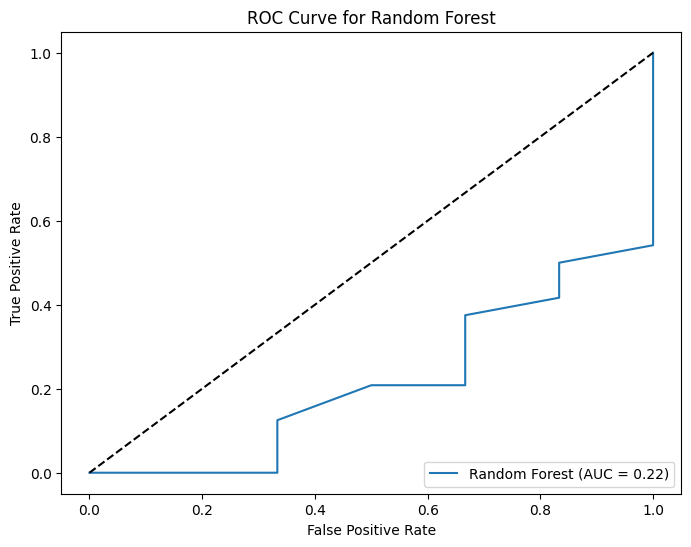

In [11]:
def evaluate_random_forest(df, target='Virtual Merchandise Purchases'):
    # Define features and target
    X = df.drop(columns=['User ID', target, 'Cluster'])  # Exclude 'User ID' and 'Cluster' from features
    y = df[target]

    # Convert target to binary: 1 if purchases > 0, else 0
    y_binary = (y > 0).astype(int)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=42, stratify=y_binary)

    # Train Random Forest
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    y_prob = rf_model.predict_proba(X_test)[:,1]

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Random Forest Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob):.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.title('ROC Curve for Random Forest')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Evaluate Random Forest with additional metrics
evaluate_random_forest(velocity_df_cleaned, target='Virtual Merchandise Purchases')


### Proposed New Fan Challenge

#### Multi-Stage Predictive Challenge: 
Fans can engage in a series of predictions throughout the race, such as:

- Predicting which vehicle will run the longest before needing a pit stop.
- Estimating the total number of pit stops within the race.
- Bonus predictions for the fastest pit stop or most efficient team recharge.

#### Engagement Strategy:
##### Dynamic Quests:
Users can participate in real-time "quest chains," where successful predictions unlock further prediction opportunities. This multi-stage challenge keeps fans engaged throughout the race.
- **Team-based challenges**: Fans can align with their favorite teams and make predictions for their chosen team to unlock special rewards.

##### Social Competition:
Leaderboard rankings for teams and individuals will foster a competitive environment. Fans can climb leaderboards by earning points from accurate predictions, with bonus rewards for prediction streaks.

#### Monetization Strategy:
##### Exclusive Team Merchandise:
Offer team-aligned fans exclusive, team-branded merchandise as a reward for participating in and completing challenges.

##### Real-Time Upselling:
Provide limited-time offers on team-themed merchandise for users who successfully reach prediction milestones during races. For instance, fans who predict 3 pit stops correctly may unlock discounts on pit stop-themed virtual merchandise.

##### In-App Purchases:
Introduce "prediction power-ups," such as hints or extra chances to make predictions. These power-ups can be purchased with in-app currency or real money, enhancing the user experience while driving monetization.

#### Predicted Outcomes:
- **Increased User Engagement**: Gamified, multi-stage challenges keep users engaged throughout the race, offering continuous interaction.
- **Higher Merchandise Sales**: By incentivizing fans to complete quest chains and align with teams, users are encouraged to purchase exclusive team merchandise.
- **Enhanced Sponsorship Value**: Sponsors gain additional visibility as their ads are featured throughout the challenge stages, and sponsorship rewards (such as exclusive content) can be directly integrated into the challenge structure.